# Ontology-Driven Clinical Decision Support - End-to-End Experiments

This notebook provides a comprehensive end-to-end experimentation pipeline for the Lung Cancer Assistant (LCA) system.

## Experiments Covered

1. **Environment Setup & Validation**
2. **Ontology Construction & Inspection** (LUCADA + SNOMED-CT)
3. **Guideline Rules Engine** (NICE CG121)
4. **Individual Agent Testing** (all 6 core agents)
5. **Full 6-Agent Workflow** (LangGraph pipeline)
6. **Specialized Agents** (Biomarker, NSCLC, Comorbidity)
7. **Multi-Patient Cohort Processing**
8. **Synthetic Data Generation & Batch Analysis**
9. **Analytics** (Survival, Uncertainty, Counterfactual)
10. **Visualization & Reporting**

---
## 1. Environment Setup & Validation

In [1]:
import sys
import os
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Ensure project root is on the path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '.'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print(f"Project root: {PROJECT_ROOT}")
print(f"Python version: {sys.version}")

Project root: h:\akash\git\CoherencePLM\Version22
Python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]


In [2]:
# Validate core dependencies
dependencies = {
    'pydantic': 'pydantic',
    'owlready2': 'owlready2',
    'rdflib': 'rdflib',
    'numpy': 'numpy',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
}

optional_deps = {
    'langchain': 'langchain',
    'langgraph': 'langgraph',
    'neo4j': 'neo4j',
    'lifelines': 'lifelines',
    'sentence_transformers': 'sentence-transformers',
}

print("=== Core Dependencies ===")
for name, pkg in dependencies.items():
    try:
        mod = __import__(name)
        ver = getattr(mod, '__version__', 'installed')
        print(f"  [OK] {pkg}: {ver}")
    except ImportError:
        print(f"  [MISSING] {pkg} - install with: pip install {pkg}")

print("\n=== Optional Dependencies ===")
for name, pkg in optional_deps.items():
    try:
        mod = __import__(name)
        ver = getattr(mod, '__version__', 'installed')
        print(f"  [OK] {pkg}: {ver}")
    except ImportError:
        print(f"  [SKIP] {pkg} - not installed (some experiments will use fallbacks)")

=== Core Dependencies ===
  [OK] pydantic: 2.12.5
  [OK] owlready2: installed
  [OK] rdflib: 7.5.0
  [OK] numpy: 2.4.1
  [OK] pandas: 2.3.3
  [OK] matplotlib: 3.10.8
  [OK] seaborn: 0.13.2

=== Optional Dependencies ===
  [OK] langchain: 1.2.6
  [OK] langgraph: installed
  [OK] neo4j: 6.1.0
  [OK] lifelines: 0.30.0
  [OK] sentence-transformers: 5.2.0


In [3]:
# Common imports used throughout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pprint import pprint

# Plotting config
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid')

print("Common imports loaded.")

Common imports loaded.


---
## 2. Ontology Construction & Inspection

Build the LUCADA OWL 2 ontology and inspect its structure.

In [30]:
from backend.src.ontology.lucada_ontology import LUCADAOntology
from backend.src.ontology.snomed_loader import SNOMEDLoader

# Create the ontology
lucada = LUCADAOntology()
onto = lucada.create()


print(f"Ontology IRI: {onto.base_iri}")
print(f"Number of classes: {len(list(onto.classes()))}")
print(f"Number of object properties: {len(list(onto.object_properties()))}")
print(f"Number of data properties: {len(list(onto.data_properties()))}")
lucada_ontology_owl = lucada.save("H:\\akash\\git\\CoherencePLM\\Version22\\data\\lca_ontologies\\lucada\\lucada_ontology.owl")
print(f"Ontology saved: {lucada_ontology_owl}")

[INFO    ] | 2026-02-06 20:37:30.491 | lca.ontology.snomed_loader | SNOMED OWL file found at H:\akash\git\CoherencePLM\Version22\data\lca_ontologies\snomed_ct\build_snonmed_owl\snomed_ct_optimized.owl
[INFO    ] | 2026-02-06 20:37:30.494 | lca.ontology.lucada_ontology | Creating LUCADA ontology...
[INFO    ] | 2026-02-06 20:37:30.533 | lca.ontology.lucada_ontology | ✓ LUCADA ontology created successfully
[INFO    ] | 2026-02-06 20:37:30.535 | lca.ontology.lucada_ontology |   Classes: 68
[INFO    ] | 2026-02-06 20:37:30.537 | lca.ontology.lucada_ontology |   Object Properties: 15
[INFO    ] | 2026-02-06 20:37:30.539 | lca.ontology.lucada_ontology |   Data Properties: 36
Ontology IRI: http://www.ox.ac.uk/lucada#
Number of classes: 68
Number of object properties: 15
Number of data properties: 36
[INFO    ] | 2026-02-06 20:37:30.551 | lca.ontology.lucada_ontology | ✓ Ontology saved to: H:\akash\git\CoherencePLM\Version22\data\lca_ontologies\lucada\lucada_ontology.owl
Ontology saved: None


In [36]:
print(lucada_ontology_owl)

None


In [31]:
# List all ontology classes grouped by hierarchy
print("=== LUCADA Ontology Classes ===")
for cls in sorted(onto.classes(), key=lambda c: c.name):
    parents = [p.name for p in cls.is_a if hasattr(p, 'name')]
    print(f"  {cls.name} -> subclass of: {parents}")

=== LUCADA Ontology Classes ===
  ALKNegative -> subclass of: ['ALKRearrangement']
  ALKPositive -> subclass of: ['ALKRearrangement']
  ALKRearrangement -> subclass of: ['Biomarker']
  ActiveMonitoring -> subclass of: ['TherapeuticProcedure']
  Adenocarcinoma -> subclass of: ['NonSmallCellCarcinoma']
  Argument -> subclass of: ['Argumentation']
  Argumentation -> subclass of: ['Thing']
  Biomarker -> subclass of: ['ClinicalFinding']
  BodyStructure -> subclass of: ['SNOMEDConcept']
  Brachytherapy -> subclass of: ['TherapeuticProcedure']
  Bronchoscopy -> subclass of: ['EvaluationProcedure']
  COPD -> subclass of: ['Comorbidity']
  CTGuidedBiopsy -> subclass of: ['EvaluationProcedure']
  CTScan -> subclass of: ['EvaluationProcedure']
  Carcinosarcoma -> subclass of: ['Histology']
  CardiovascularDisease -> subclass of: ['Comorbidity']
  Chemoradiotherapy -> subclass of: ['TherapeuticProcedure']
  Chemotherapy -> subclass of: ['TherapeuticProcedure']
  ClinicalFinding -> subclass of: ['

In [32]:
# Inspect SNOMED-CT mappings
snomed = SNOMEDLoader()
print("=== SNOMED-CT Lung Cancer Codes ===")

for concept_name, code in sorted(snomed.LUNG_CANCER_CONCEPTS.items()):
    print(f"  {concept_name}: {code}")

print(f"\nTotal SNOMED codes available: {len(snomed.LUNG_CANCER_CONCEPTS)}")

[INFO    ] | 2026-02-06 20:37:51.352 | lca.ontology.snomed_loader | SNOMED OWL file found at H:\akash\git\CoherencePLM\Version22\data\lca_ontologies\snomed_ct\build_snonmed_owl\snomed_ct_optimized.owl
=== SNOMED-CT Lung Cancer Codes ===
  adenocarcinoma: 35917007
  alk_fusion_positive_nsclc: 830151004
  bilateral_lungs: 51185008
  body_structure: 123037004
  carcinosarcoma: 128885008
  chemoradiotherapy: 703423002
  chemotherapy: 367336001
  clinical_finding: 404684003
  complete_response: 268910001
  disease_free_survival: 313239003
  egfr_negative_nsclc: 427038005
  egfr_positive_nsclc: 426964009
  immunotherapy: 76334006
  large_cell_carcinoma: 67101007
  left_lung: 44029006
  lobectomy: 173171007
  lower_lobe_lung: 4029006
  malignant_neoplasm_lung: 363358000
  middle_lobe_lung: 72481006
  neoplastic_disease: 64572001
  nsclc: 254637007
  nsclc_adenocarcinoma: 1255725002
  nsclc_stage_1: 424132000
  nsclc_stage_2: 425048006
  nsclc_stage_3: 422968005
  nsclc_stage_4: 423121009
  ov

None


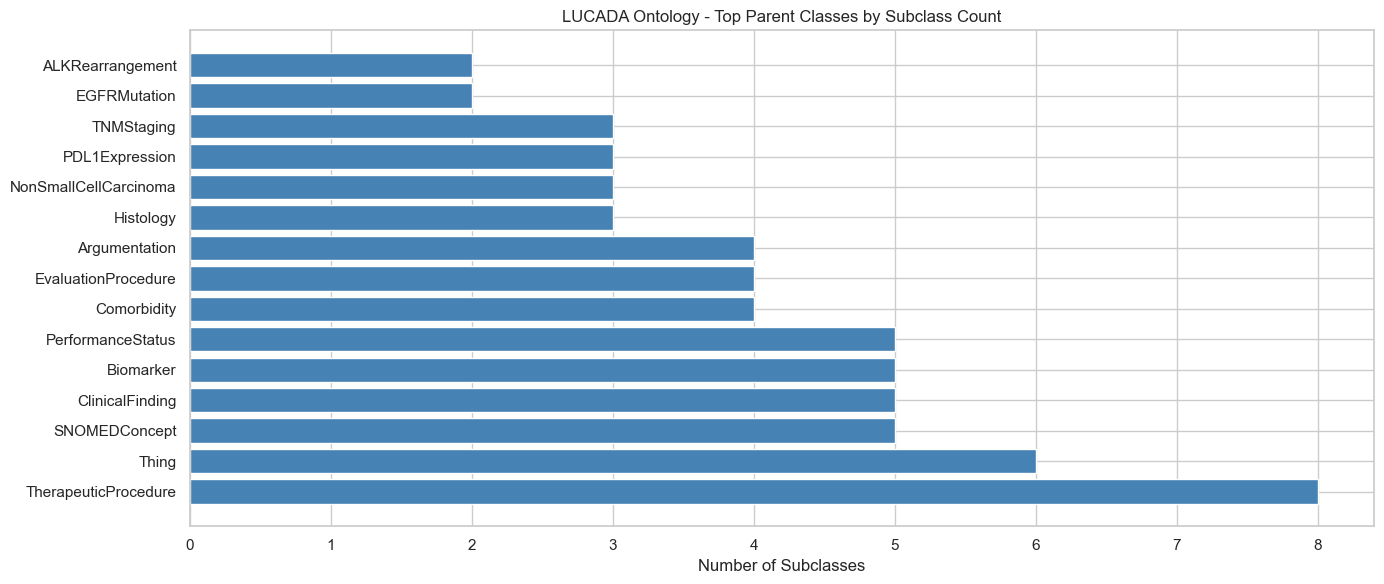

In [33]:
# Visualize ontology class hierarchy
class_names = [cls.name for cls in onto.classes()]
parent_counts = {}
for cls in onto.classes():
    for parent in cls.is_a:
        if hasattr(parent, 'name'):
            parent_counts[parent.name] = parent_counts.get(parent.name, 0) + 1

if parent_counts:
    fig, ax = plt.subplots(figsize=(14, 6))
    top_parents = dict(sorted(parent_counts.items(), key=lambda x: x[1], reverse=True)[:15])
    ax.barh(list(top_parents.keys()), list(top_parents.values()), color='steelblue')
    ax.set_xlabel('Number of Subclasses')
    ax.set_title('LUCADA Ontology - Top Parent Classes by Subclass Count')
    plt.tight_layout()
    plt.show()
else:
    print("No parent hierarchy data to visualize.")

---
## 3. Guideline Rules Engine (NICE CG121)

Test the clinical guideline rules that drive treatment recommendations.

In [54]:
from backend.src.ontology.guideline_rules import GuidelineRuleEngine, GuidelineRule

print("=== Testing GuidelineRuleEngine ===")

# Create instance - requires the lucada ontology instance
rule_engine = GuidelineRuleEngine(lucada)

print("=== NICE Lung Cancer Guideline Rules ===")
print(f"Total rules loaded: {len(rule_engine.NICE_GUIDELINES)}\n")

for rule in rule_engine.NICE_GUIDELINES:
    print(f"Rule {rule.rule_id}: {rule.name}")
    print(f"  Source: {rule.source}")
    print(f"  Treatment: {rule.recommended_treatment}")
    print(f"  Intent: {rule.treatment_intent}")
    print(f"  Evidence: {rule.evidence_level}")
    print(f"  Description: {rule.description[:100]}...")
    print()

=== Testing GuidelineRuleEngine ===
[INFO    ] | 2026-02-06 20:49:00.477 | lca.ontology.guideline_rules | Loading clinical guideline rules...
[INFO    ] | 2026-02-06 20:49:00.483 | lca.ontology.guideline_rules | ✓ Loaded 11 guideline rules
=== NICE Lung Cancer Guideline Rules ===
Total rules loaded: 11

Rule R1: ChemoRule001_AdvancedNSCLC
  Source: NICE Lung Cancer 2011 - CG121
  Treatment: Chemotherapy
  Intent: Palliative
  Evidence: Grade A
  Description: Offer chemotherapy to patients with stage III or IV NSCLC and good performance status (WHO 0-1)...

Rule R2: SurgeryRule001_EarlyStageNSCLC
  Source: NICE Lung Cancer 2011 - CG121
  Treatment: Surgery
  Intent: Curative
  Evidence: Grade A
  Description: Offer surgery to patients with stage I-II NSCLC and good performance status...

Rule R3: RadioRule001_InoperableNSCLC
  Source: NICE Lung Cancer 2011 - CG121
  Treatment: Radiotherapy
  Intent: Curative
  Evidence: Grade B
  Description: Offer radical radiotherapy for stage I-III N

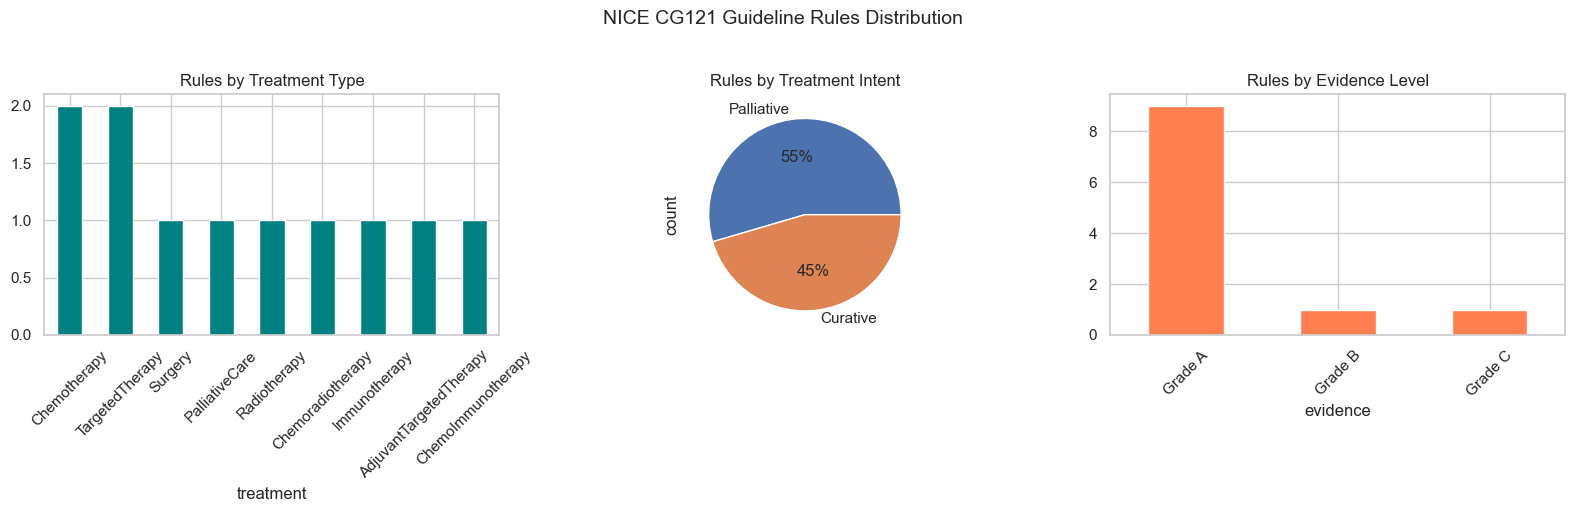

In [55]:
# Visualize guideline rule distribution
rules_df = pd.DataFrame([
    {
        'rule_id': r.rule_id,
        'treatment': r.recommended_treatment,
        'intent': r.treatment_intent,
        'evidence': r.evidence_level
    }
    for r in rule_engine.NICE_GUIDELINES
])

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Treatment types
rules_df['treatment'].value_counts().plot(kind='bar', ax=axes[0], color='teal')
axes[0].set_title('Rules by Treatment Type')
axes[0].tick_params(axis='x', rotation=45)

# Treatment intent
rules_df['intent'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.0f%%')
axes[1].set_title('Rules by Treatment Intent')

# Evidence level
rules_df['evidence'].value_counts().plot(kind='bar', ax=axes[2], color='coral')
axes[2].set_title('Rules by Evidence Level')
axes[2].tick_params(axis='x', rotation=45)

plt.suptitle('NICE CG121 Guideline Rules Distribution', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## 4. Individual Agent Testing

Test each of the 6 core agents independently.

In [56]:
# Define test patients
test_patients = [
    {
        "name": "Jenny_Sesen",
        "sex": "F",
        "age": 72,
        "tnm_stage": "IIA",
        "histology_type": "Carcinosarcoma",
        "performance_status": 1,
        "fev1_percent": 75.0,
        "laterality": "Right",
        "comorbidities": [],
        "notes": "Canonical example from Sesen et al. paper"
    },
    {
        "name": "John_Smith",
        "sex": "M",
        "age": 65,
        "tnm_stage": "IB",
        "histology_type": "Adenocarcinoma",
        "performance_status": 0,
        "fev1_percent": 85.0,
        "laterality": "Left",
        "comorbidities": [],
        "notes": "Early stage NSCLC, ideal surgery candidate"
    },
    {
        "name": "Mary_Williams",
        "sex": "F",
        "age": 58,
        "tnm_stage": "IIIA",
        "histology_type": "SquamousCellCarcinoma",
        "performance_status": 1,
        "fev1_percent": 70.0,
        "laterality": "Right",
        "comorbidities": ["COPD"],
        "notes": "Locally advanced NSCLC with COPD"
    },
    {
        "name": "Robert_Johnson",
        "sex": "M",
        "age": 68,
        "tnm_stage": "IV",
        "histology_type": "Adenocarcinoma",
        "performance_status": 1,
        "fev1_percent": None,
        "laterality": "Right",
        "comorbidities": ["Hypertension"],
        "notes": "Metastatic NSCLC"
    },
    {
        "name": "Sarah_Davis",
        "sex": "F",
        "age": 62,
        "tnm_stage": "IIIB",
        "histology_type": "SmallCellCarcinoma",
        "performance_status": 2,
        "fev1_percent": 55.0,
        "laterality": "Left",
        "comorbidities": ["COPD", "Diabetes"],
        "notes": "SCLC with multiple comorbidities"
    }
]

print(f"Defined {len(test_patients)} test patients.")
for p in test_patients:
    print(f"  - {p['name']}: {p['histology_type']}, Stage {p['tnm_stage']}, PS {p['performance_status']}")

Defined 5 test patients.
  - Jenny_Sesen: Carcinosarcoma, Stage IIA, PS 1
  - John_Smith: Adenocarcinoma, Stage IB, PS 0
  - Mary_Williams: SquamousCellCarcinoma, Stage IIIA, PS 1
  - Robert_Johnson: Adenocarcinoma, Stage IV, PS 1
  - Sarah_Davis: SmallCellCarcinoma, Stage IIIB, PS 2


### 4.1 Agent 1: Ingestion Agent

In [57]:
from backend.src.agents.ingestion_agent import IngestionAgent

ingestion_agent = IngestionAgent()

print("=== Ingestion Agent Results ===")
ingested_patients = []
for patient_data in test_patients:
    patient_fact, errors = ingestion_agent.execute(patient_data)
    if patient_fact:
        ingested_patients.append(patient_fact)
        print(f"\n[OK] {patient_fact.name}")
        print(f"  Patient ID: {patient_fact.patient_id}")
        print(f"  Stage: {patient_fact.tnm_stage}, Histology: {patient_fact.histology_type}")
        print(f"  PS: {patient_fact.performance_status}, FEV1: {patient_fact.fev1_percent}")
    else:
        print(f"\n[ERROR] {patient_data['name']}: {errors}")

print(f"\nSuccessfully ingested: {len(ingested_patients)}/{len(test_patients)}")

=== Ingestion Agent Results ===
[INFO    ] | 2026-02-06 20:50:29.869 | lca.agents.ingestion_agent | ============================================================
[INFO    ] | 2026-02-06 20:50:29.870 | lca.agents.ingestion_agent | [IngestionAgent] STARTING EXECUTION
[INFO    ] | 2026-02-06 20:50:29.873 | lca.agents.ingestion_agent | ============================================================
[INFO    ] | 2026-02-06 20:50:29.874 | lca.agents.ingestion_agent | [IngestionAgent] INPUT DATA:
[INFO    ] | 2026-02-06 20:50:29.877 | lca.agents.ingestion_agent |   • name: Jenny_Sesen
[INFO    ] | 2026-02-06 20:50:29.880 | lca.agents.ingestion_agent |   • sex: F
[INFO    ] | 2026-02-06 20:50:29.882 | lca.agents.ingestion_agent |   • age: 72
[INFO    ] | 2026-02-06 20:50:29.886 | lca.agents.ingestion_agent |   • tnm_stage: IIA
[INFO    ] | 2026-02-06 20:50:29.888 | lca.agents.ingestion_agent |   • histology_type: Carcinosarcoma
[INFO    ] | 2026-02-06 20:50:29.890 | lca.agents.ingestion_agent |   

In [58]:
# Test edge cases for ingestion
edge_cases = [
    {"name": "Invalid_Stage", "sex": "M", "age": 50, "tnm_stage": "Stage IIIA",
     "histology_type": "adenocarcinoma", "performance_status": 1},
    {"name": "Missing_Fields", "sex": "F", "age": 45},
    {"name": "Extreme_Age", "sex": "M", "age": 95, "tnm_stage": "IV",
     "histology_type": "SmallCellCarcinoma", "performance_status": 3},
]

print("=== Edge Case Testing ===")
for case in edge_cases:
    patient_fact, errors = ingestion_agent.execute(case)
    status = "OK" if patient_fact else "REJECTED"
    print(f"  [{status}] {case['name']}: errors={errors}")

=== Edge Case Testing ===
[INFO    ] | 2026-02-06 20:51:33.379 | lca.agents.ingestion_agent | ============================================================
[INFO    ] | 2026-02-06 20:51:33.381 | lca.agents.ingestion_agent | [IngestionAgent] STARTING EXECUTION
[INFO    ] | 2026-02-06 20:51:33.384 | lca.agents.ingestion_agent | ============================================================
[INFO    ] | 2026-02-06 20:51:33.386 | lca.agents.ingestion_agent | [IngestionAgent] INPUT DATA:
[INFO    ] | 2026-02-06 20:51:33.390 | lca.agents.ingestion_agent |   • name: Invalid_Stage
[INFO    ] | 2026-02-06 20:51:33.393 | lca.agents.ingestion_agent |   • sex: M
[INFO    ] | 2026-02-06 20:51:33.395 | lca.agents.ingestion_agent |   • age: 50
[INFO    ] | 2026-02-06 20:51:33.397 | lca.agents.ingestion_agent |   • tnm_stage: Stage IIIA
[INFO    ] | 2026-02-06 20:51:33.398 | lca.agents.ingestion_agent |   • histology_type: adenocarcinoma
[INFO    ] | 2026-02-06 20:51:33.401 | lca.agents.ingestion_agent |

### 4.2 Agent 2: Semantic Mapping Agent

In [59]:
from backend.src.agents.semantic_mapping_agent import SemanticMappingAgent

semantic_agent = SemanticMappingAgent()

print("=== Semantic Mapping Results ===")
mapped_patients = []
for patient_fact in ingested_patients:
    patient_with_codes, confidence = semantic_agent.execute(patient_fact)
    mapped_patients.append(patient_with_codes)
    print(f"\n{patient_fact.name} (confidence: {confidence:.2f})")
    print(f"  SNOMED Diagnosis: {patient_with_codes.snomed_diagnosis_code}")
    print(f"  SNOMED Histology: {patient_with_codes.snomed_histology_code}")
    print(f"  SNOMED Stage: {patient_with_codes.snomed_stage_code}")
    print(f"  SNOMED PS: {patient_with_codes.snomed_ps_code}")
    print(f"  SNOMED Laterality: {patient_with_codes.snomed_laterality_code}")

=== Semantic Mapping Results ===
[INFO    ] | 2026-02-06 20:52:34.460 | lca.agents.semantic_mapping_agent | [SemanticMappingAgent] Mapping patient B441A43F to SNOMED-CT...
[INFO    ] | 2026-02-06 20:52:34.463 | lca.agents.semantic_mapping_agent | [SemanticMappingAgent] ✓ Mapped B441A43F with confidence 0.96

Jenny_Sesen (confidence: 0.96)
  SNOMED Diagnosis: 363358000
  SNOMED Histology: 128885008
  SNOMED Stage: 425048006
  SNOMED PS: 373804000
  SNOMED Laterality: 39607008
[INFO    ] | 2026-02-06 20:52:34.464 | lca.agents.semantic_mapping_agent | [SemanticMappingAgent] Mapping patient 8E9A8138 to SNOMED-CT...
[INFO    ] | 2026-02-06 20:52:34.469 | lca.agents.semantic_mapping_agent | [SemanticMappingAgent] ✓ Mapped 8E9A8138 with confidence 0.96

John_Smith (confidence: 0.96)
  SNOMED Diagnosis: 363358000
  SNOMED Histology: 35917007
  SNOMED Stage: 424132000
  SNOMED PS: 373803006
  SNOMED Laterality: 44029006
[INFO    ] | 2026-02-06 20:52:34.471 | lca.agents.semantic_mapping_agent | 

### 4.3 Agent 3: Classification Agent

In [60]:
from backend.src.agents.classification_agent import ClassificationAgent

classification_agent = ClassificationAgent()

print("=== Classification Results ===")
classifications = []
for patient in mapped_patients:
    result = classification_agent.execute(patient)
    classifications.append(result)
    print(f"\n{patient.name}:")
    print(f"  Scenario: {result.scenario}")
    print(f"  Confidence: {result.scenario_confidence:.2f}")
    print(f"  Reasoning: {result.reasoning_chain[:3]}")
    print(f"  Guidelines matched: {result.guideline_refs}")
    print(f"  Recommendations:")
    for rec in result.recommendations[:3]:
        print(f"    - {rec}")

=== Classification Results ===
[INFO    ] | 2026-02-06 20:52:45.618 | lca.agents.classification_agent | [ClassificationAgent] Classifying patient B441A43F...
[INFO    ] | 2026-02-06 20:52:45.618 | lca.agents.classification_agent | [ClassificationAgent] ✓ Classified B441A43F as early_stage_operable

Jenny_Sesen:
  Scenario: early_stage_operable
  Confidence: 0.90
  Reasoning: ['Patient presents with Carcinosarcoma lung cancer', 'TNM Stage: IIA', 'ECOG Performance Status: 1']
  Guidelines matched: ['NICE NG122 1.4.9', 'NICE NG122 1.4.1']
  Recommendations:
    - {'rank': 1, 'treatment': 'Surgical resection (lobectomy preferred)', 'evidence_level': 'Grade A', 'intent': 'Curative', 'guideline_reference': 'NICE NG122 1.4.1', 'rationale': 'Lobectomy is the preferred surgical approach for early-stage NSCLC with good PS', 'contraindications': [], 'requires_biomarker': None}
    - {'rank': 2, 'treatment': 'SABR if unfit for surgery', 'evidence_level': 'Grade A', 'intent': 'Curative', 'guideline

### 4.4 Agent 4: Conflict Resolution Agent

In [61]:
from backend.src.agents.conflict_resolution_agent import ConflictResolutionAgent

conflict_agent = ConflictResolutionAgent()

print("=== Conflict Resolution Results ===")
resolved_classifications = []
all_conflict_reports = []
for i, classification in enumerate(classifications):
    resolved, conflicts = conflict_agent.execute(classification)
    resolved_classifications.append(resolved)
    all_conflict_reports.append(conflicts)
    print(f"\n{mapped_patients[i].name}:")
    print(f"  Conflicts found: {len(conflicts)}")
    for c in conflicts:
        print(f"    - Type: {c.conflict_type}, Resolution: {c.resolution}")
    print(f"  Resolved scenario: {resolved.scenario}")
    print(f"  Final recommendations: {len(resolved.recommendations)}")

=== Conflict Resolution Results ===
[INFO    ] | 2026-02-06 20:52:52.068 | lca.agents.conflict_resolution_agent | [ConflictResolutionAgent] Resolving conflicts for patient B441A43F...
[INFO    ] | 2026-02-06 20:52:52.071 | lca.agents.conflict_resolution_agent | [ConflictResolutionAgent] ✓ Resolved 1 conflicts for B441A43F

Jenny_Sesen:
  Conflicts found: 1
    - Type: surgery_vs_radiotherapy, Resolution: Prefer 'Surgical resection (lobectomy preferred)' based on evidence level
  Resolved scenario: early_stage_operable
  Final recommendations: 2
[INFO    ] | 2026-02-06 20:52:52.072 | lca.agents.conflict_resolution_agent | [ConflictResolutionAgent] Resolving conflicts for patient 8E9A8138...
[INFO    ] | 2026-02-06 20:52:52.072 | lca.agents.conflict_resolution_agent | [ConflictResolutionAgent] ✓ Resolved 1 conflicts for 8E9A8138

John_Smith:
  Conflicts found: 1
    - Type: surgery_vs_radiotherapy, Resolution: Prefer 'Surgical resection (lobectomy preferred)' based on evidence level
  Re

### 4.5 Agent 6: Explanation Agent

Note: The ExplanationAgent generates MDT summaries. If Ollama is not available, it falls back to template-based generation.

In [63]:
from backend.src.agents.explanation_agent import ExplanationAgent

explanation_agent = ExplanationAgent()

print("=== MDT Summary Generation ===")
mdt_summaries = []
for i, (patient, classification) in enumerate(zip(mapped_patients, resolved_classifications)):
    try:
        # Fixed: use 'patient' and 'classification' as parameter names
        summary = explanation_agent.execute(
            patient=patient,
            classification=classification
        )
        mdt_summaries.append(summary)
        print(f"\n{'='*60}")
        print(f"MDT Summary for {patient.name}")
        print(f"{'='*60}")
        print(f"Clinical Summary: {summary.clinical_summary[:200]}...")
        print(f"Scenario: {summary.classification_scenario}")
        print(f"Confidence: {summary.scenario_confidence:.2f}")
        print(f"Key Considerations: {summary.key_considerations[:3]}")
        print(f"Discussion Points: {summary.discussion_points[:3]}")
    except Exception as e:
        print(f"\n[WARN] {patient.name}: Explanation generation failed - {e}")
        mdt_summaries.append(None)

=== MDT Summary Generation ===
[INFO    ] | 2026-02-06 20:54:10.213 | lca.agents.explanation_agent | [ExplanationAgent] Generating MDT summary for patient B441A43F...
[INFO    ] | 2026-02-06 20:54:10.220 | lca.agents.explanation_agent | [ExplanationAgent] ✓ Generated MDT summary for B441A43F

MDT Summary for Jenny_Sesen
Clinical Summary: 72 year old F patient diagnosed with Carcinosarcoma of the lung (Right side) at TNM Stage IIA. ECOG Performance Status is 1. Based on NICE guidelines, this case is classified as 'early_stage_operable'...
Scenario: early_stage_operable
Confidence: 0.90
Key Considerations: []
Discussion Points: ['Confirm TNM staging with radiology review', 'Review pathology for complete histological classification', 'Assess surgical fitness and patient preference']
[INFO    ] | 2026-02-06 20:54:10.224 | lca.agents.explanation_agent | [ExplanationAgent] Generating MDT summary for patient 8E9A8138...
[INFO    ] | 2026-02-06 20:54:10.225 | lca.agents.explanation_agent | [Ex

---
## 5. Full 6-Agent Workflow (LangGraph Pipeline)

Run the complete end-to-end workflow through all 6 agents.

In [ ]:
from backend.src.agents.lca_workflow import LCAWorkflow

# Initialize workflow with Neo4j persistence enabled
workflow = LCAWorkflow(persist_results=True)

print("=== Full 6-Agent Workflow Execution ===")
workflow_results = []

for patient_data in test_patients:
    print(f"\nProcessing: {patient_data['name']}")
    start_time = time.time()
    
    try:
        result = workflow.run(patient_data)
        elapsed = time.time() - start_time
        workflow_results.append({
            'name': patient_data['name'],
            'result': result,
            'time_seconds': elapsed,
            'success': True
        })
        
        print(f"  Status: {result.get('workflow_status', 'unknown')}")
        print(f"  Agent Chain: {result.get('agent_chain', [])}")
        print(f"  Time: {elapsed:.2f}s")
        
        if result.get('classification'):
            cls = result['classification']
            scenario = cls.scenario if hasattr(cls, 'scenario') else str(cls)
            print(f"  Scenario: {scenario}")
        
        if result.get('mdt_summary'):
            summary = result['mdt_summary']
            text = summary.clinical_summary if hasattr(summary, 'clinical_summary') else str(summary)
            print(f"  MDT Summary: {text[:150]}...")
    except Exception as e:
        elapsed = time.time() - start_time
        workflow_results.append({
            'name': patient_data['name'],
            'result': None,
            'time_seconds': elapsed,
            'success': False,
            'error': str(e)
        })
        print(f"  [ERROR] {e}")

# Summary
successes = sum(1 for r in workflow_results if r['success'])
print(f"\n=== Workflow Summary ===")
print(f"Total: {len(workflow_results)}, Success: {successes}, Failed: {len(workflow_results) - successes}")
print(f"Avg time: {np.mean([r['time_seconds'] for r in workflow_results]):.2f}s")

=== Full 6-Agent Workflow Execution ===

Processing: Jenny_Sesen
[INFO    ] | 2026-02-06 20:54:29.812 | lca.agents.lca_workflow | [Workflow] Running IngestionAgent...
[INFO    ] | 2026-02-06 20:54:29.812 | lca.agents.ingestion_agent | ============================================================
[INFO    ] | 2026-02-06 20:54:29.812 | lca.agents.ingestion_agent | [IngestionAgent] STARTING EXECUTION
[INFO    ] | 2026-02-06 20:54:29.812 | lca.agents.ingestion_agent | ============================================================
[INFO    ] | 2026-02-06 20:54:29.829 | lca.agents.ingestion_agent | [IngestionAgent] INPUT DATA:
[INFO    ] | 2026-02-06 20:54:29.831 | lca.agents.ingestion_agent |   • name: Jenny_Sesen
[INFO    ] | 2026-02-06 20:54:29.833 | lca.agents.ingestion_agent |   • sex: F
[INFO    ] | 2026-02-06 20:54:29.835 | lca.agents.ingestion_agent |   • age: 72
[INFO    ] | 2026-02-06 20:54:29.838 | lca.agents.ingestion_agent |   • tnm_stage: IIA
[INFO    ] | 2026-02-06 20:54:29.838 |

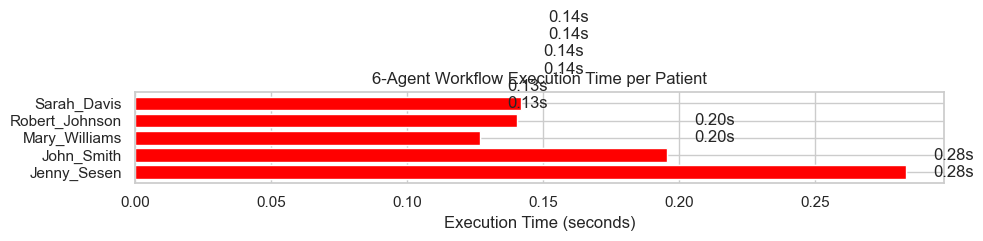

In [65]:
# Visualize workflow execution times
fig, ax = plt.subplots(figsize=(10, 5))
names = [r['name'] for r in workflow_results]
times = [r['time_seconds'] for r in workflow_results]
colors = ['green' if r['success'] else 'red' for r in workflow_results]

ax.barh(names, times, color=colors)
ax.set_xlabel('Execution Time (seconds)')
ax.set_title('6-Agent Workflow Execution Time per Patient')
for i, v in enumerate(times):
    ax.text(v + 0.01, i, f'{v:.2f}s', va='center')
plt.tight_layout()
plt.show()

---
## 6. Specialized Agents

Test the domain-specific specialized agents.

In [66]:
from backend.src.agents.biomarker_agent import BiomarkerAgent, BiomarkerProfile

biomarker_agent = BiomarkerAgent()

# Test with different biomarker profiles
biomarker_profiles = [
    BiomarkerProfile(egfr_mutation="positive", egfr_mutation_type="Ex19del", pdl1_tps=80.0),
    BiomarkerProfile(alk_rearrangement="positive", pdl1_tps=30.0),
    BiomarkerProfile(pdl1_tps=90.0, tmb_score=15.0),
    BiomarkerProfile(braf_mutation="positive"),
    BiomarkerProfile(),  # No actionable mutations
]

print("=== Biomarker Agent Results ===")
# Use the advanced NSCLC patient for biomarker testing
if len(mapped_patients) >= 4:
    test_patient = mapped_patients[3]  # Robert_Johnson, Stage IV Adenocarcinoma
    for i, profile in enumerate(biomarker_profiles):
        proposal = biomarker_agent.execute(test_patient, biomarker_profile=profile)
        print(f"\nProfile {i+1}: {profile}")
        print(f"  Treatment: {proposal.treatment}")
        print(f"  Confidence: {proposal.confidence:.2f}")
        print(f"  Rationale: {proposal.rationale[:150]}")

=== Biomarker Agent Results ===
[INFO    ] | 2026-02-06 20:54:43.182 | lca.agents.biomarker_agent | Biomarker Agent analyzing patient 8CEB9B58
[INFO    ] | 2026-02-06 20:54:43.182 | lca.agents.biomarker_agent | Biomarker Agent recommends: Osimertinib (1st-line)

Profile 1: BiomarkerProfile(egfr_mutation='positive', egfr_mutation_type='Ex19del', alk_rearrangement=None, ros1_rearrangement=None, braf_mutation=None, met_exon14_skipping=None, ret_rearrangement=None, kras_mutation=None, pdl1_tps=80.0, tmb_score=None, her2_mutation=None, ntrk_fusion=None)
  Treatment: Osimertinib (1st-line)
  Confidence: 0.95
  Rationale: EGFR Ex19del sensitizing mutation. Osimertinib first-line per FLAURA trial (median PFS 18.9 months vs 10.2 for 1st-gen TKIs).
[INFO    ] | 2026-02-06 20:54:43.192 | lca.agents.biomarker_agent | Biomarker Agent analyzing patient 8CEB9B58
[INFO    ] | 2026-02-06 20:54:43.195 | lca.agents.biomarker_agent | Biomarker Agent recommends: Alectinib (first-line ALK inhibitor)

Profil

In [71]:
from backend.src.agents.nsclc_agent import NSCLCAgent

nsclc_agent = NSCLCAgent()

print("=== NSCLC Agent - Stage-Specific Pathways ===")
for patient in mapped_patients:
    # Skip SCLC patients
    if patient.histology_type in ['SmallCellCarcinoma']:
        continue
    try:
        proposal = nsclc_agent.execute(patient)
        print(f"\n{patient.name} (Stage {patient.tnm_stage}, {patient.histology_type}):")
        print(f"  Treatment: {proposal.treatment}")
        print(f"  Confidence: {proposal.confidence:.2f}")
        print(f"  Rationale: {proposal.rationale[:200]}")
    except Exception as e:
        print(f"\n{patient.name}: Error - {e}")

=== NSCLC Agent - Stage-Specific Pathways ===

Jenny_Sesen (Stage IIA, Carcinosarcoma):
  Treatment: Surgery followed by adjuvant chemotherapy
  Confidence: 0.88
  Rationale: Resectable locally advanced NSCLC - multimodality therapy

John_Smith (Stage IB, Adenocarcinoma):
  Treatment: Surgical resection (lobectomy preferred)
  Confidence: 0.90
  Rationale: Early-stage NSCLC with good PS - surgery is standard of care

Mary_Williams (Stage IIIA, SquamousCellCarcinoma):
  Treatment: Concurrent chemoradiotherapy followed by durvalumab
  Confidence: 0.90
  Rationale: Unresectable Stage III NSCLC - PACIFIC regimen

Robert_Johnson (Stage IV, Adenocarcinoma):
  Treatment: Carboplatin + pemetrexed
  Confidence: 0.82
  Rationale: Metastatic non-squamous NSCLC - platinum/pemetrexed


In [72]:
from backend.src.agents.comorbidity_agent import ComorbidityAgent

comorbidity_agent = ComorbidityAgent()

print("=== Comorbidity Agent Results ===")
for i, patient in enumerate(mapped_patients):
    try:
        # Get the recommended treatment from the resolved classification
        classification = resolved_classifications[i]
        # Recommendations are dictionaries with a 'treatment' key
        if classification.recommendations:
            first_rec = classification.recommendations[0]
            # Extract the treatment string from the dictionary
            treatment = first_rec['treatment'] if isinstance(first_rec, dict) else first_rec
        else:
            treatment = "Chemotherapy"  # default fallback
        
        assessment = comorbidity_agent.execute(patient, treatment=treatment)
        print(f"\n{patient.name} (comorbidities: {patient.comorbidities}):")
        print(f"  Treatment assessed: {treatment}")
        print(f"  Overall Safety: {assessment.overall_safety}")
        print(f"  Risk Score: {assessment.risk_score:.2f}")
        print(f"  Contraindications: {assessment.contraindications}")
        print(f"  Warnings: {assessment.warnings}")
        if assessment.dose_adjustments:
            print(f"  Dose Adjustments: {assessment.dose_adjustments}")
        if assessment.alternative_if_unsafe:
            print(f"  Alternative Treatment: {assessment.alternative_if_unsafe}")
    except Exception as e:
        print(f"\n{patient.name}: Error - {e}")

=== Comorbidity Agent Results ===
[INFO    ] | 2026-02-06 21:04:58.590 | lca.agents.comorbidity_agent | Comorbidity Agent assessing safety for Surgical resection (lobectomy preferred)

Jenny_Sesen (comorbidities: []):
  Treatment assessed: Surgical resection (lobectomy preferred)
  Overall Safety: Safe
  Risk Score: 0.00
  Contraindications: []
  Warnings: []
[INFO    ] | 2026-02-06 21:04:58.593 | lca.agents.comorbidity_agent | Comorbidity Agent assessing safety for Surgical resection (lobectomy preferred)

John_Smith (comorbidities: []):
  Treatment assessed: Surgical resection (lobectomy preferred)
  Overall Safety: Safe
  Risk Score: 0.00
  Contraindications: []
  Warnings: []
[INFO    ] | 2026-02-06 21:04:58.597 | lca.agents.comorbidity_agent | Comorbidity Agent assessing safety for Concurrent chemoradiotherapy

Mary_Williams (comorbidities: ['COPD']):
  Treatment assessed: Concurrent chemoradiotherapy
  Overall Safety: Safe
  Risk Score: 0.00
  Contraindications: []
  Warnings: []

---
## 7. Multi-Patient Cohort Processing

Process a larger cohort from the sample patients and analyze distribution.

In [73]:
from data.sample_patients import SAMPLE_PATIENTS

print(f"Sample patients available: {len(SAMPLE_PATIENTS)}")
for p in SAMPLE_PATIENTS:
    print(f"  - {p['name']}: Stage {p['tnm_stage']}, {p['histology_type']}, PS {p['performance_status']}")

Sample patients available: 11
  - Jenny_Sesen: Stage IIA, Carcinosarcoma, PS 1
  - John_Smith: Stage IB, Adenocarcinoma, PS 0
  - Mary_Williams: Stage IIIA, SquamousCellCarcinoma, PS 1
  - Robert_Johnson: Stage IV, Adenocarcinoma, PS 1
  - Susan_Davis: Stage IIIA, SmallCellCarcinoma, PS 1
  - William_Brown: Stage IV, LargeCellCarcinoma, PS 3
  - Elizabeth_Miller: Stage IV, Adenocarcinoma, PS 0
  - James_Wilson: Stage IIIB, Adenocarcinoma, PS 1
  - Patricia_Anderson: Stage IV, Adenocarcinoma, PS 1
  - Thomas_Taylor: Stage IIB, SquamousCellCarcinoma, PS 2
  - Jennifer_Martinez: Stage IV, SmallCellCarcinoma, PS 1


In [74]:
# Process all sample patients through the ingestion + classification pipeline
cohort_results = []

for patient_data in SAMPLE_PATIENTS:
    try:
        # Ingestion
        patient_fact, errors = ingestion_agent.execute(patient_data)
        if not patient_fact:
            continue
        
        # Semantic mapping
        patient_with_codes, confidence = semantic_agent.execute(patient_fact)
        
        # Classification
        classification = classification_agent.execute(patient_with_codes)
        
        cohort_results.append({
            'name': patient_data['name'],
            'stage': patient_data['tnm_stage'],
            'histology': patient_data['histology_type'],
            'ps': patient_data['performance_status'],
            'age': patient_data['age'],
            'scenario': classification.scenario,
            'confidence': classification.scenario_confidence,
            'num_recommendations': len(classification.recommendations),
            'guidelines': classification.guideline_refs,
            'mapping_confidence': confidence
        })
    except Exception as e:
        print(f"Error processing {patient_data.get('name', 'unknown')}: {e}")

cohort_df = pd.DataFrame(cohort_results)
print(f"\nCohort processed: {len(cohort_df)} patients")
cohort_df

[INFO    ] | 2026-02-06 21:05:40.299 | lca.agents.ingestion_agent | ============================================================
[INFO    ] | 2026-02-06 21:05:40.299 | lca.agents.ingestion_agent | [IngestionAgent] STARTING EXECUTION
[INFO    ] | 2026-02-06 21:05:40.299 | lca.agents.ingestion_agent | ============================================================
[INFO    ] | 2026-02-06 21:05:40.308 | lca.agents.ingestion_agent | [IngestionAgent] INPUT DATA:
[INFO    ] | 2026-02-06 21:05:40.311 | lca.agents.ingestion_agent |   • patient_id: Jenny_Sesen_200312
[INFO    ] | 2026-02-06 21:05:40.314 | lca.agents.ingestion_agent |   • name: Jenny_Sesen
[INFO    ] | 2026-02-06 21:05:40.316 | lca.agents.ingestion_agent |   • sex: F
[INFO    ] | 2026-02-06 21:05:40.319 | lca.agents.ingestion_agent |   • age: 72
[INFO    ] | 2026-02-06 21:05:40.321 | lca.agents.ingestion_agent |   • diagnosis: Malignant Neoplasm of Lung
[INFO    ] | 2026-02-06 21:05:40.324 | lca.agents.ingestion_agent |   • tnm_sta

,name,stage,histology,ps,age,scenario,confidence,num_recommendations,guidelines,mapping_confidence
0,Jenny_Sesen,IIA,Carcinosarcoma,1,72,early_stage_operable,0.90,2,"[NICE NG122 1.4.9, NICE NG122 1.4.1]",0.96
1,John_Smith,IB,Adenocarcinoma,0,65,early_stage_operable,0.90,2,"[NICE NG122 1.4.9, NICE NG122 1.4.1]",0.96
2,Mary_Williams,IIIA,SquamousCellCarcinoma,1,58,locally_advanced_resectable,0.85,2,"[NICE NG122 1.4.21, NICE NG122 1.4.18]",0.96
3,Robert_Johnson,IV,Adenocarcinoma,1,68,metastatic_good_ps,0.90,3,"[NICE TA683, NICE TA654 (EGFR), TA670 (ALK), N...",0.96
4,Susan_Davis,IIIA,SmallCellCarcinoma,1,62,sclc_limited,0.95,2,"[NICE NG122 1.6.3, NICE NG122 1.6.1]",0.96
5,William_Brown,IV,LargeCellCarcinoma,3,78,metastatic_poor_ps,0.90,2,"[NICE NG122 1.5.1, NICE NG122 1.5.3]",0.96
6,Elizabeth_Miller,IV,Adenocarcinoma,0,55,metastatic_good_ps,0.90,3,"[NICE TA683, NICE TA654 (EGFR), TA670 (ALK), N...",0.96
7,James_Wilson,IIIB,Adenocarcinoma,1,48,locally_advanced_unresectable,0.90,2,"[NICE NG122 1.4.20, NICE NG122 1.4.18 + TA798]",0.96
8,Patricia_Anderson,IV,Adenocarcinoma,1,42,metastatic_good_ps,0.90,3,"[NICE TA683, NICE TA654 (EGFR), TA670 (ALK), N...",0.96
9,Thomas_Taylor,IIB,SquamousCellCarcinoma,2,70,early_stage_inoperable,0.85,2,"[NICE NG122 1.4.9, NICE NG122 1.4.12]",0.96


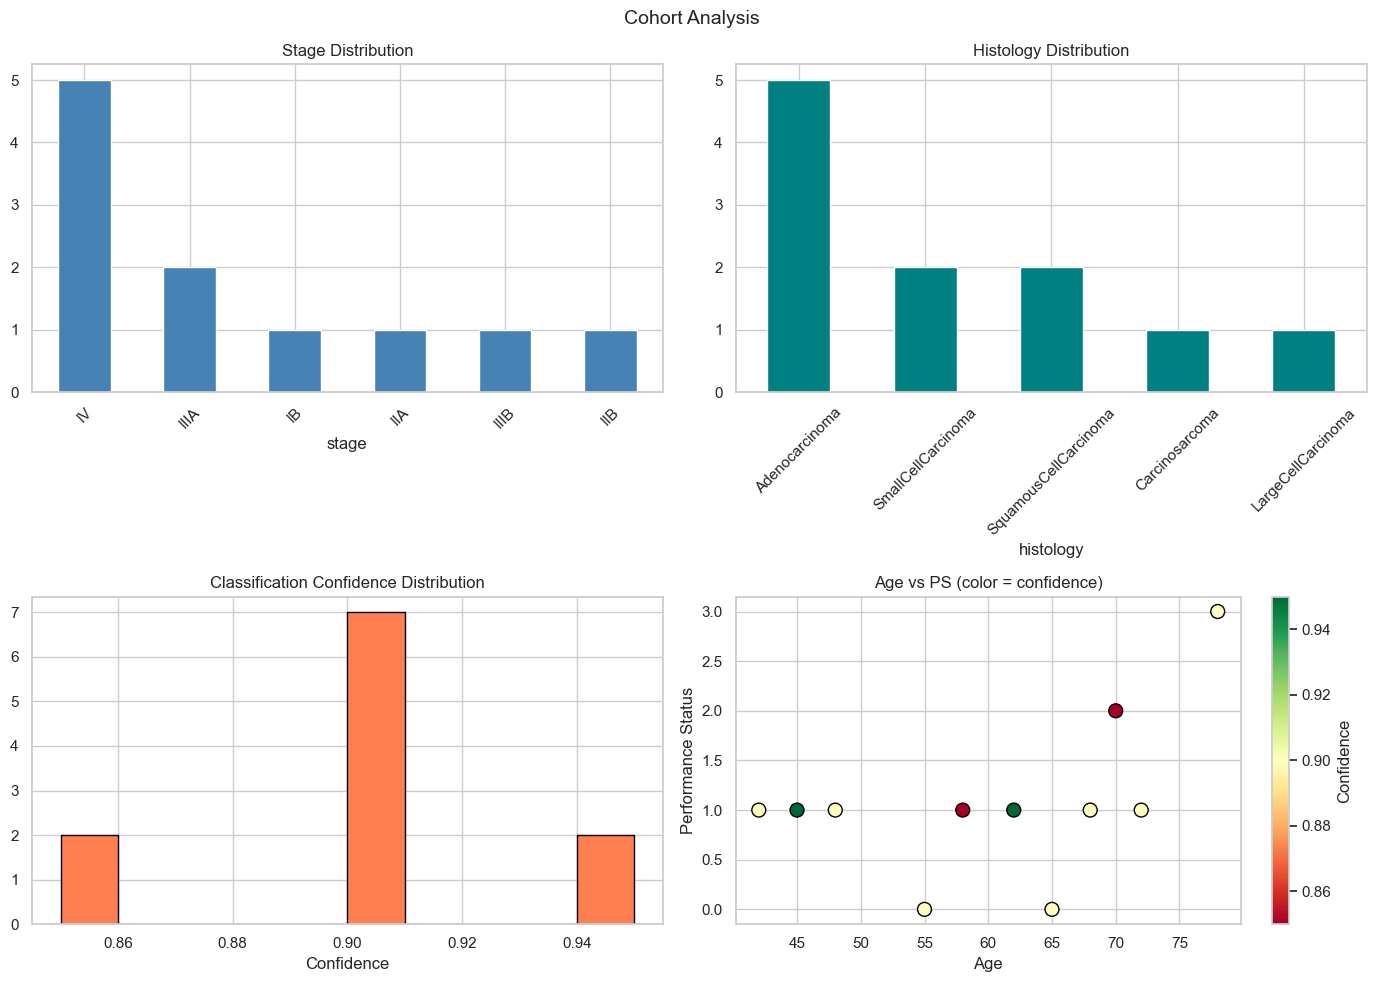

In [75]:
# Cohort analysis visualizations
if len(cohort_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Stage distribution
    cohort_df['stage'].value_counts().plot(kind='bar', ax=axes[0, 0], color='steelblue')
    axes[0, 0].set_title('Stage Distribution')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Histology distribution
    cohort_df['histology'].value_counts().plot(kind='bar', ax=axes[0, 1], color='teal')
    axes[0, 1].set_title('Histology Distribution')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Classification confidence
    axes[1, 0].hist(cohort_df['confidence'], bins=10, color='coral', edgecolor='black')
    axes[1, 0].set_title('Classification Confidence Distribution')
    axes[1, 0].set_xlabel('Confidence')
    
    # Age vs Performance Status
    scatter = axes[1, 1].scatter(
        cohort_df['age'], cohort_df['ps'],
        c=cohort_df['confidence'], cmap='RdYlGn', s=100, edgecolors='black'
    )
    axes[1, 1].set_xlabel('Age')
    axes[1, 1].set_ylabel('Performance Status')
    axes[1, 1].set_title('Age vs PS (color = confidence)')
    plt.colorbar(scatter, ax=axes[1, 1], label='Confidence')
    
    plt.suptitle('Cohort Analysis', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No cohort data to visualize.")

---
## 8. Synthetic Data Generation & Batch Analysis

Generate a larger synthetic cohort and run batch processing.

In [76]:
from data.synthetic_patient_generator import SyntheticPatientGenerator

generator = SyntheticPatientGenerator()

# Generate 50 synthetic patients
N_SYNTHETIC = 50
synthetic_patients = [generator.generate_patient() for _ in range(N_SYNTHETIC)]

print(f"Generated {len(synthetic_patients)} synthetic patients")
print(f"\nStage distribution:")
stage_counts = {}
for p in synthetic_patients:
    stage_counts[p.tnm_stage] = stage_counts.get(p.tnm_stage, 0) + 1
for stage, count in sorted(stage_counts.items()):
    print(f"  {stage}: {count} ({count/len(synthetic_patients)*100:.0f}%)")

Generated 50 synthetic patients

Stage distribution:
  IA: 5 (10%)
  IB: 3 (6%)
  IIA: 7 (14%)
  IIB: 8 (16%)
  IIIA: 9 (18%)
  IIIB: 10 (20%)
  IV: 8 (16%)


In [77]:
# Batch process synthetic patients through the pipeline
batch_results = []
batch_errors = []

print(f"Processing {N_SYNTHETIC} synthetic patients...")
start_time = time.time()

for i, patient in enumerate(synthetic_patients):
    try:
        patient_data = patient.to_dict()
        patient_data['name'] = patient.name  # ensure name field
        
        # Ingestion
        patient_fact, errors = ingestion_agent.execute(patient_data)
        if not patient_fact:
            batch_errors.append({'patient': patient.name, 'stage': 'ingestion', 'error': str(errors)})
            continue
        
        # Semantic mapping
        patient_with_codes, confidence = semantic_agent.execute(patient_fact)
        
        # Classification
        classification = classification_agent.execute(patient_with_codes)
        
        # Conflict resolution
        resolved, conflicts = conflict_agent.execute(classification)
        
        batch_results.append({
            'name': patient.name,
            'age': patient.age_at_diagnosis,
            'sex': patient.sex,
            'stage': patient.tnm_stage,
            'histology': patient.histology_type,
            'ps': patient.performance_status,
            'fev1': patient.fev1_percent,
            'comorbidities': len(patient.comorbidities or []),
            'scenario': resolved.scenario,
            'confidence': resolved.scenario_confidence,
            'num_recommendations': len(resolved.recommendations),
            'num_conflicts': len(conflicts),
            'mapping_confidence': confidence
        })
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i+1}/{N_SYNTHETIC}...")
            
    except Exception as e:
        batch_errors.append({'patient': patient.name, 'stage': 'pipeline', 'error': str(e)})

total_time = time.time() - start_time
batch_df = pd.DataFrame(batch_results)

print(f"\n=== Batch Processing Complete ===")
print(f"Total time: {total_time:.2f}s")
print(f"Success: {len(batch_results)}, Errors: {len(batch_errors)}")
print(f"Throughput: {len(batch_results)/total_time:.1f} patients/sec")

Processing 50 synthetic patients...
[INFO    ] | 2026-02-06 21:06:32.529 | lca.agents.ingestion_agent | ============================================================
[INFO    ] | 2026-02-06 21:06:32.532 | lca.agents.ingestion_agent | [IngestionAgent] STARTING EXECUTION
[INFO    ] | 2026-02-06 21:06:32.534 | lca.agents.ingestion_agent | ============================================================
[INFO    ] | 2026-02-06 21:06:32.537 | lca.agents.ingestion_agent | [IngestionAgent] INPUT DATA:
[INFO    ] | 2026-02-06 21:06:32.539 | lca.agents.ingestion_agent |   • patient_id: 807DE292
[INFO    ] | 2026-02-06 21:06:32.543 | lca.agents.ingestion_agent |   • name: Robert Williams
[INFO    ] | 2026-02-06 21:06:32.546 | lca.agents.ingestion_agent |   • sex: M
[INFO    ] | 2026-02-06 21:06:32.548 | lca.agents.ingestion_agent |   • age_at_diagnosis: 70
[INFO    ] | 2026-02-06 21:06:32.550 | lca.agents.ingestion_agent |   • tnm_stage: IIIB
[INFO    ] | 2026-02-06 21:06:32.552 | lca.agents.ingestio

In [78]:
# Comprehensive batch analysis
if len(batch_df) > 0:
    print("=== Batch Statistics ===")
    print(f"\nConfidence: mean={batch_df['confidence'].mean():.3f}, "
          f"std={batch_df['confidence'].std():.3f}, "
          f"min={batch_df['confidence'].min():.3f}, "
          f"max={batch_df['confidence'].max():.3f}")
    print(f"\nMapping confidence: mean={batch_df['mapping_confidence'].mean():.3f}")
    print(f"\nRecommendations per patient: mean={batch_df['num_recommendations'].mean():.1f}")
    print(f"Conflicts per patient: mean={batch_df['num_conflicts'].mean():.1f}")
    
    print(f"\nScenario distribution:")
    for scenario, count in batch_df['scenario'].value_counts().items():
        print(f"  {scenario}: {count} ({count/len(batch_df)*100:.0f}%)")

=== Batch Statistics ===

Confidence: mean=0.899, std=0.031, min=0.850, max=0.950

Mapping confidence: mean=0.960

Recommendations per patient: mean=2.1
Conflicts per patient: mean=0.6

Scenario distribution:
  early_stage_operable: 15 (30%)
  locally_advanced_unresectable: 13 (26%)
  sclc_limited: 7 (14%)
  early_stage_inoperable: 4 (8%)
  metastatic_poor_ps: 4 (8%)
  metastatic_good_ps: 3 (6%)
  sclc_extensive: 2 (4%)
  locally_advanced_resectable: 2 (4%)


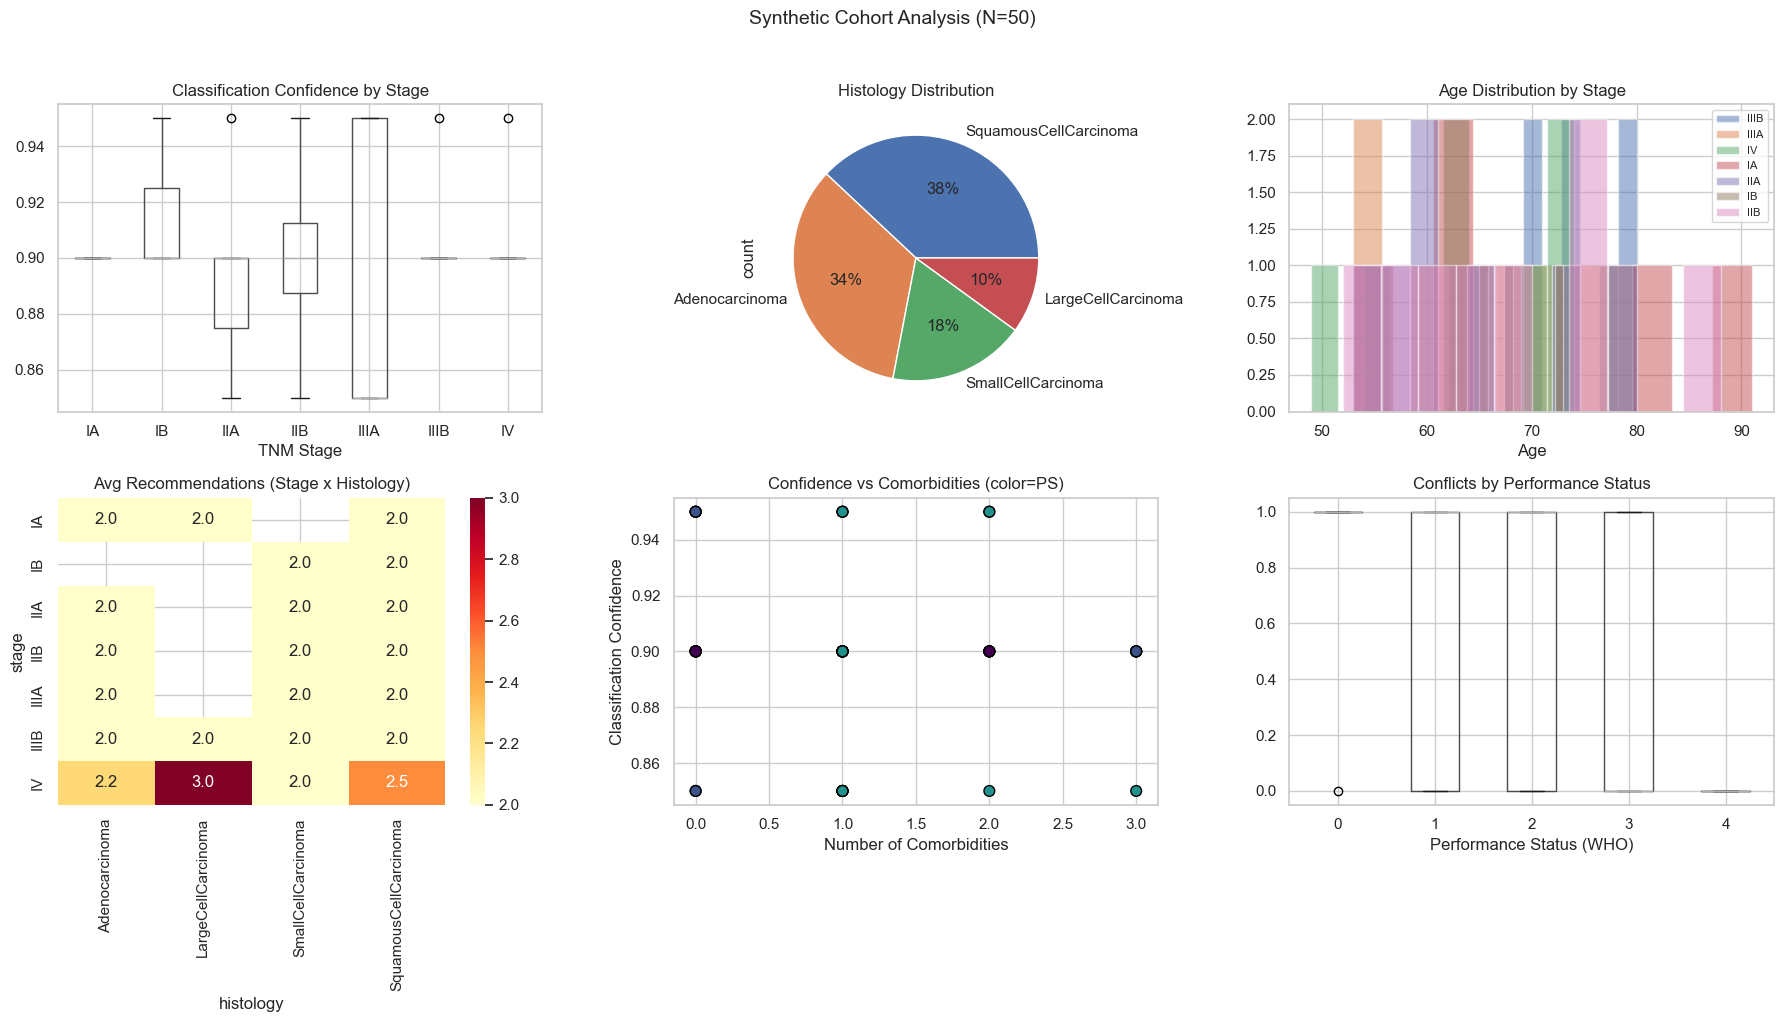

In [79]:
# Batch visualizations
if len(batch_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Stage vs Confidence
    batch_df.boxplot(column='confidence', by='stage', ax=axes[0, 0])
    axes[0, 0].set_title('Classification Confidence by Stage')
    axes[0, 0].set_xlabel('TNM Stage')
    
    # 2. Histology distribution
    batch_df['histology'].value_counts().plot(kind='pie', ax=axes[0, 1], autopct='%1.0f%%')
    axes[0, 1].set_title('Histology Distribution')
    
    # 3. Age distribution by stage
    for stage in batch_df['stage'].unique():
        subset = batch_df[batch_df['stage'] == stage]
        axes[0, 2].hist(subset['age'], alpha=0.5, label=stage, bins=10)
    axes[0, 2].set_title('Age Distribution by Stage')
    axes[0, 2].set_xlabel('Age')
    axes[0, 2].legend(fontsize=8)
    
    # 4. Recommendations heatmap: stage x histology
    pivot = batch_df.pivot_table(
        values='num_recommendations', index='stage', columns='histology', aggfunc='mean'
    )
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1, 0])
    axes[1, 0].set_title('Avg Recommendations (Stage x Histology)')
    
    # 5. Confidence vs number of comorbidities
    axes[1, 1].scatter(batch_df['comorbidities'], batch_df['confidence'],
                       c=batch_df['ps'], cmap='viridis', s=60, edgecolors='black')
    axes[1, 1].set_xlabel('Number of Comorbidities')
    axes[1, 1].set_ylabel('Classification Confidence')
    axes[1, 1].set_title('Confidence vs Comorbidities (color=PS)')
    
    # 6. Performance status vs conflicts
    batch_df.boxplot(column='num_conflicts', by='ps', ax=axes[1, 2])
    axes[1, 2].set_title('Conflicts by Performance Status')
    axes[1, 2].set_xlabel('Performance Status (WHO)')
    
    plt.suptitle(f'Synthetic Cohort Analysis (N={len(batch_df)})', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

---
## 9. Analytics Modules

Test survival analysis, uncertainty quantification, and counterfactual reasoning.

### 9.1 Survival Analysis

In [80]:
from backend.src.analytics.survival_analyzer import SurvivalAnalyzer

survival_analyzer = SurvivalAnalyzer()

# Generate synthetic survival data for demonstration
np.random.seed(42)
n_patients = 100

survival_data = []
for _ in range(n_patients):
    stage = np.random.choice(['IA', 'IB', 'IIA', 'IIB', 'IIIA', 'IIIB', 'IV'],
                             p=[0.10, 0.08, 0.12, 0.10, 0.15, 0.15, 0.30])
    treatment = np.random.choice(['Surgery', 'Chemotherapy', 'Chemoradiotherapy', 'Immunotherapy'])
    
    # Simulate survival based on stage
    base_survival = {'IA': 1800, 'IB': 1500, 'IIA': 1200, 'IIB': 1000,
                     'IIIA': 700, 'IIIB': 500, 'IV': 300}
    survival_days = max(30, int(np.random.exponential(base_survival[stage])))
    event = 1 if np.random.random() < 0.7 else 0  # 70% observed events
    
    survival_data.append({
        'patient_id': f'SYN-{_:03d}',
        'stage': stage,
        'treatment': treatment,
        'survival_days': survival_days,
        'event': event
    })

survival_df = pd.DataFrame(survival_data)
print(f"Survival dataset: {len(survival_df)} patients")
print(f"\nMedian survival by stage:")
print(survival_df.groupby('stage')['survival_days'].median().sort_values(ascending=False))

Survival dataset: 100 patients

Median survival by stage:
stage
IIA     1111.0
IB      1089.0
IIB      911.0
IA       892.0
IIIA     456.5
IIIB     363.5
IV       116.0
Name: survival_days, dtype: float64


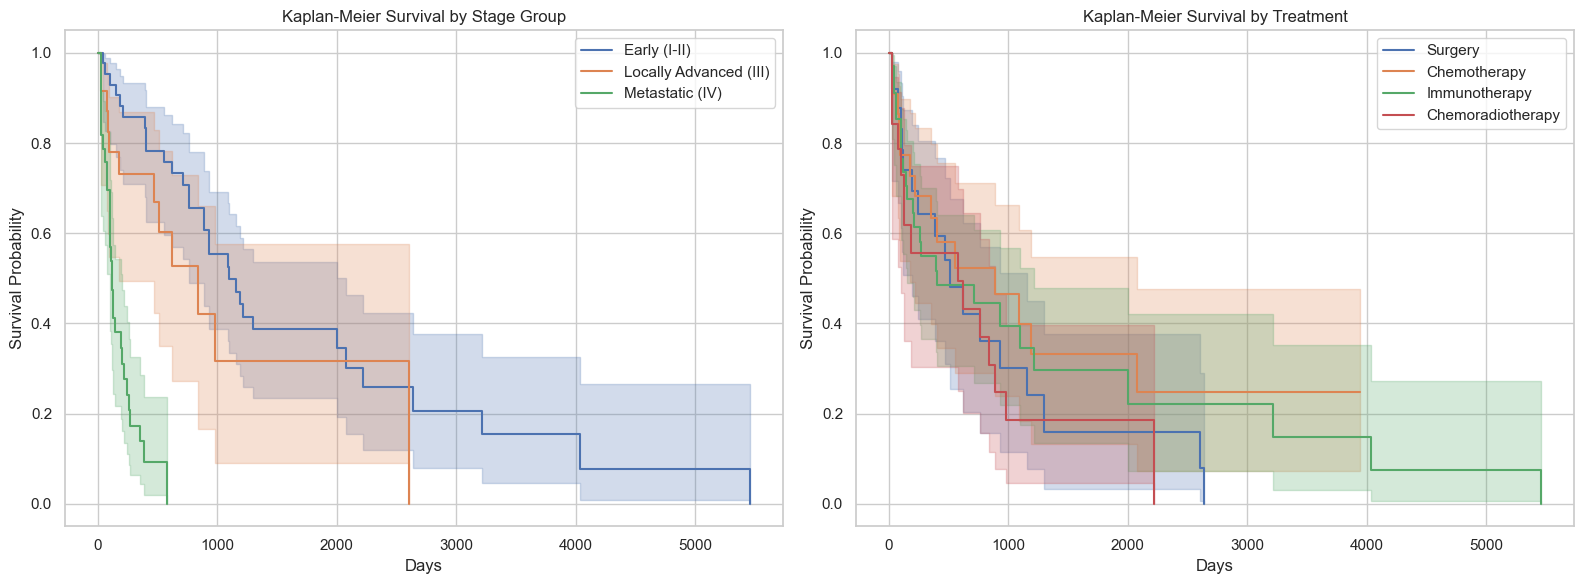

Log-rank test (Early vs Metastatic): p=0.0000


In [81]:
# Kaplan-Meier survival curves by stage
try:
    from lifelines import KaplanMeierFitter
    from lifelines.statistics import logrank_test
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # By stage (grouped for clarity)
    kmf = KaplanMeierFitter()
    stage_groups = {'Early (I-II)': ['IA', 'IB', 'IIA', 'IIB'],
                    'Locally Advanced (III)': ['IIIA', 'IIIB'],
                    'Metastatic (IV)': ['IV']}
    
    for label, stages in stage_groups.items():
        mask = survival_df['stage'].isin(stages)
        kmf.fit(survival_df.loc[mask, 'survival_days'],
                event_observed=survival_df.loc[mask, 'event'],
                label=label)
        kmf.plot_survival_function(ax=axes[0])
    
    axes[0].set_title('Kaplan-Meier Survival by Stage Group')
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Survival Probability')
    
    # By treatment
    for treatment in survival_df['treatment'].unique():
        mask = survival_df['treatment'] == treatment
        kmf.fit(survival_df.loc[mask, 'survival_days'],
                event_observed=survival_df.loc[mask, 'event'],
                label=treatment)
        kmf.plot_survival_function(ax=axes[1])
    
    axes[1].set_title('Kaplan-Meier Survival by Treatment')
    axes[1].set_xlabel('Days')
    axes[1].set_ylabel('Survival Probability')
    
    plt.tight_layout()
    plt.show()
    
    # Log-rank test: early vs metastatic
    early = survival_df[survival_df['stage'].isin(['IA', 'IB', 'IIA', 'IIB'])]
    metastatic = survival_df[survival_df['stage'] == 'IV']
    result = logrank_test(
        early['survival_days'], metastatic['survival_days'],
        event_observed_A=early['event'], event_observed_B=metastatic['event']
    )
    print(f"Log-rank test (Early vs Metastatic): p={result.p_value:.4f}")
    
except ImportError:
    print("lifelines not installed. Showing basic survival statistics instead.")
    print(survival_df.groupby('stage')['survival_days'].describe())

### 9.2 Uncertainty Quantification

In [82]:
from backend.src.analytics.uncertainty_quantifier import UncertaintyQuantifier
from backend.src.db.models import TreatmentRecommendation, EvidenceLevel, TreatmentIntent

uq = UncertaintyQuantifier()

print("=== Uncertainty Quantification ===")

# Create sample recommendations for uncertainty analysis
sample_recommendations = [
    TreatmentRecommendation(
        patient_id="TEST-001",
        primary_treatment="Surgery (Lobectomy)",
        treatment_intent=TreatmentIntent.CURATIVE,
        evidence_level=EvidenceLevel.GRADE_A,
        confidence_score=0.92,
        rationale="Early stage NSCLC with good PS - standard surgical approach",
        guideline_references=["NICE CG121 R2"]
    ),
    TreatmentRecommendation(
        patient_id="TEST-002",
        primary_treatment="Concurrent Chemoradiotherapy",
        treatment_intent=TreatmentIntent.CURATIVE,
        evidence_level=EvidenceLevel.GRADE_B,
        confidence_score=0.75,
        rationale="Locally advanced NSCLC with comorbidities",
        guideline_references=["NICE CG121 R6"]
    ),
    TreatmentRecommendation(
        patient_id="TEST-003",
        primary_treatment="Palliative Chemotherapy",
        treatment_intent=TreatmentIntent.PALLIATIVE,
        evidence_level=EvidenceLevel.GRADE_A,
        confidence_score=0.85,
        rationale="Metastatic NSCLC, PS 1",
        guideline_references=["NICE CG121 R1"]
    ),
]

uncertainty_results = []
for i, (rec, patient) in enumerate(zip(sample_recommendations, ingested_patients[:3])):
    try:
        metrics = uq.quantify_recommendation_uncertainty(rec, patient)
        uncertainty_results.append(metrics)
        print(f"\n{patient.name} - {rec.primary_treatment}:")
        print(f"  Confidence: {metrics.confidence_score:.3f}")
        print(f"  Epistemic uncertainty: {metrics.epistemic_uncertainty:.3f}")
        print(f"  Aleatoric uncertainty: {metrics.aleatoric_uncertainty:.3f}")
        print(f"  Total uncertainty: {metrics.total_uncertainty:.3f}")
        print(f"  Confidence level: {metrics.confidence_level}")
        print(f"  Explanation: {metrics.explanation[:150]}")
    except Exception as e:
        print(f"\nError for {patient.name}: {e}")

=== Uncertainty Quantification ===

Jenny_Sesen - Surgery (Lobectomy):
  Confidence: 0.300
  Epistemic uncertainty: 0.900
  Aleatoric uncertainty: 0.500
  Total uncertainty: 0.950
  Confidence level: Low
  Explanation: No historical data available for similar patients with this treatment

John_Smith - Concurrent Chemoradiotherapy:
  Confidence: 0.300
  Epistemic uncertainty: 0.900
  Aleatoric uncertainty: 0.500
  Total uncertainty: 0.950
  Confidence level: Low
  Explanation: No historical data available for similar patients with this treatment

Mary_Williams - Palliative Chemotherapy:
  Confidence: 0.300
  Epistemic uncertainty: 0.900
  Aleatoric uncertainty: 0.500
  Total uncertainty: 0.950
  Confidence level: Low
  Explanation: No historical data available for similar patients with this treatment


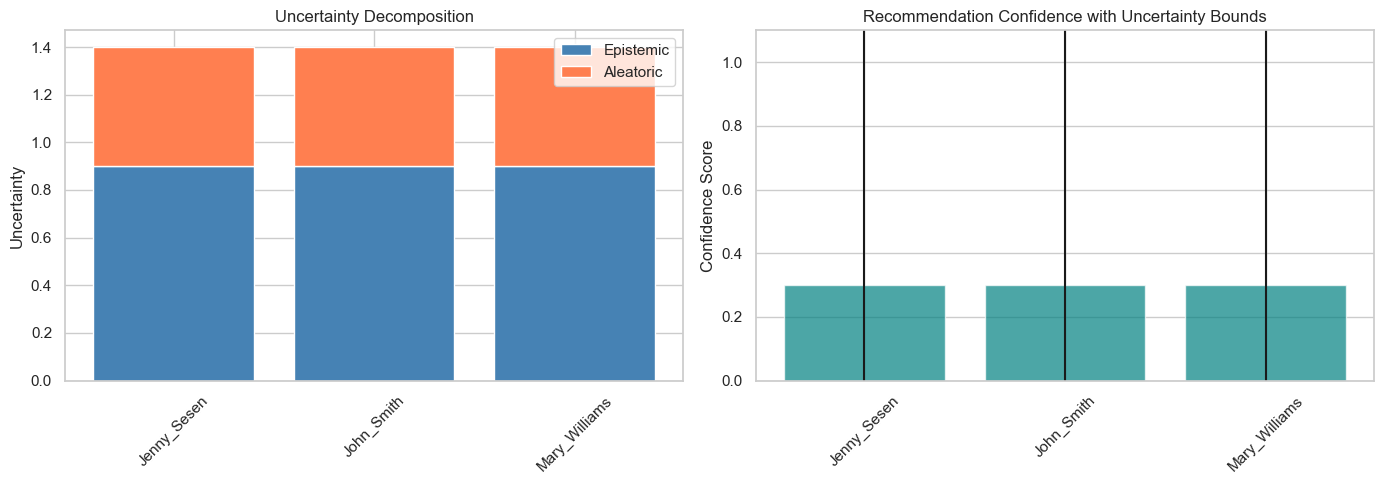

In [83]:
# Visualize uncertainty
if uncertainty_results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    names = [ingested_patients[i].name for i in range(len(uncertainty_results))]
    epistemic = [m.epistemic_uncertainty for m in uncertainty_results]
    aleatoric = [m.aleatoric_uncertainty for m in uncertainty_results]
    
    # Stacked bar: epistemic vs aleatoric
    x = np.arange(len(names))
    axes[0].bar(x, epistemic, label='Epistemic', color='steelblue')
    axes[0].bar(x, aleatoric, bottom=epistemic, label='Aleatoric', color='coral')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(names, rotation=45)
    axes[0].set_ylabel('Uncertainty')
    axes[0].set_title('Uncertainty Decomposition')
    axes[0].legend()
    
    # Confidence with error bars
    confidences = [m.confidence_score for m in uncertainty_results]
    totals = [m.total_uncertainty for m in uncertainty_results]
    axes[1].bar(x, confidences, yerr=totals, capsize=5, color='teal', alpha=0.7)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(names, rotation=45)
    axes[1].set_ylabel('Confidence Score')
    axes[1].set_title('Recommendation Confidence with Uncertainty Bounds')
    axes[1].set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()

### 9.3 Counterfactual Analysis

In [84]:
from backend.src.analytics.counterfactual_engine import CounterfactualEngine

cf_engine = CounterfactualEngine(workflow=workflow)

print("=== Counterfactual Analysis ===")
print("What-if scenarios for treatment decision sensitivity\n")

# Analyze counterfactuals for the canonical Jenny_Sesen case
jenny_data = test_patients[0]

try:
    cf_result = cf_engine.analyze_counterfactuals(
        patient_data=jenny_data,
        attributes_to_vary=['tnm_stage', 'performance_status', 'fev1_percent']
    )
    
    print(f"Patient: {cf_result.patient_id}")
    print(f"Original recommendation: {cf_result.original_recommendation}")
    print(f"\nCounterfactual scenarios:")
    for cf in cf_result.counterfactuals:
        print(f"  - {cf.get('description', cf)}")
    print(f"\nActionable interventions: {cf_result.actionable_interventions}")
    print(f"Sensitivity: {cf_result.sensitivity_analysis}")
except Exception as e:
    print(f"Counterfactual analysis error: {e}")
    print("\nRunning manual what-if analysis instead...")
    
    # Manual what-if: vary stage
    print("\nWhat-if: Stage variation for Jenny_Sesen")
    stages = ['IA', 'IIA', 'IIIA', 'IV']
    for stage in stages:
        modified = jenny_data.copy()
        modified['tnm_stage'] = stage
        pf, _ = ingestion_agent.execute(modified)
        if pf:
            pwc, _ = semantic_agent.execute(pf)
            cls = classification_agent.execute(pwc)
            print(f"  Stage {stage}: {cls.scenario} (confidence: {cls.scenario_confidence:.2f})")

=== Counterfactual Analysis ===
What-if scenarios for treatment decision sensitivity

Counterfactual analysis error: CounterfactualEngine.analyze_counterfactuals() got an unexpected keyword argument 'patient_data'

Running manual what-if analysis instead...

What-if: Stage variation for Jenny_Sesen
[INFO    ] | 2026-02-06 21:07:43.651 | lca.agents.ingestion_agent | ============================================================
[INFO    ] | 2026-02-06 21:07:43.654 | lca.agents.ingestion_agent | [IngestionAgent] STARTING EXECUTION
[INFO    ] | 2026-02-06 21:07:43.656 | lca.agents.ingestion_agent | ============================================================
[INFO    ] | 2026-02-06 21:07:43.659 | lca.agents.ingestion_agent | [IngestionAgent] INPUT DATA:
[INFO    ] | 2026-02-06 21:07:43.661 | lca.agents.ingestion_agent |   • name: Jenny_Sesen
[INFO    ] | 2026-02-06 21:07:43.662 | lca.agents.ingestion_agent |   • sex: F
[INFO    ] | 2026-02-06 21:07:43.665 | lca.agents.ingestion_agent |   • 

---
## 10. Visualization & Reporting

Generate final summary visualizations and a consolidated report.

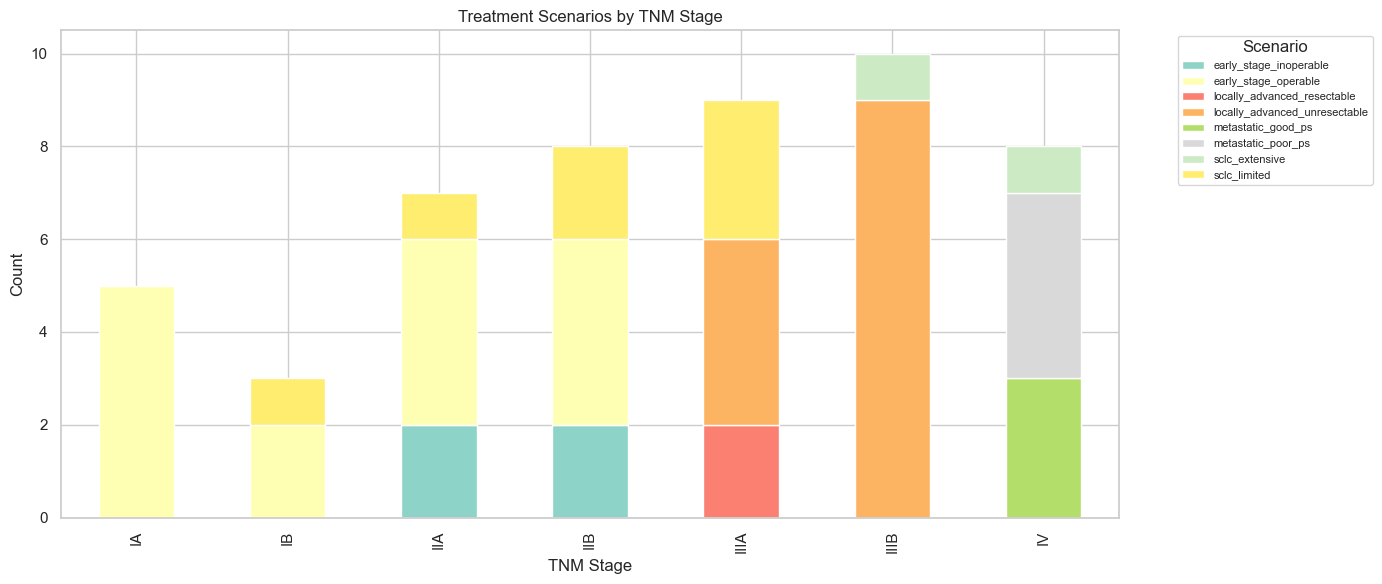

In [85]:
# Treatment recommendation decision matrix
if len(batch_df) > 0:
    # Cross-tabulation: stage x scenario
    ct = pd.crosstab(batch_df['stage'], batch_df['scenario'])
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ct.plot(kind='bar', stacked=True, ax=ax, colormap='Set3')
    ax.set_title('Treatment Scenarios by TNM Stage')
    ax.set_xlabel('TNM Stage')
    ax.set_ylabel('Count')
    ax.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()

In [90]:
# Comprehensive performance summary
print("=" * 70)
print("EXPERIMENT SUMMARY REPORT")
print("=" * 70)
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n--- Ontology ---")
print(f"  Classes: {len(list(lucada.onto.classes()))}")
print(f"  Object Properties: {len(list(lucada.onto.object_properties()))}")
print(f"  Data Properties: {len(list(lucada.onto.data_properties()))}")
print(f"  SNOMED Codes: {len(snomed.LUNG_CANCER_CONCEPTS)}")
print(f"  Guideline Rules: {len(rule_engine.NICE_GUIDELINES)}")

print(f"\n--- Agent Pipeline ---")
print(f"  Test patients processed: {len(test_patients)}")
print(f"  Workflow executions: {len(workflow_results)}")
print(f"  Workflow success rate: {successes}/{len(workflow_results)}")
if workflow_results:
    print(f"  Avg workflow time: {np.mean([r['time_seconds'] for r in workflow_results]):.2f}s")

print(f"\n--- Batch Processing ---")
print(f"  Synthetic patients: {N_SYNTHETIC}")
print(f"  Successfully processed: {len(batch_results)}")
print(f"  Errors: {len(batch_errors)}")
if len(batch_df) > 0:
    print(f"  Mean confidence: {batch_df['confidence'].mean():.3f}")
    print(f"  Mean mapping confidence: {batch_df['mapping_confidence'].mean():.3f}")
    print(f"  Throughput: {len(batch_results)/total_time:.1f} patients/sec")

print(f"\n--- Analytics ---")
print(f"  Survival dataset: {len(survival_df)} patients")
print(f"  Uncertainty quantified: {len(uncertainty_results)} recommendations")

print("\n" + "=" * 70)
print("All experiments completed.")
print("=" * 70)

EXPERIMENT SUMMARY REPORT
Date: 2026-02-06 21:11:40

--- Ontology ---
  Classes: 79
  Object Properties: 15
  Data Properties: 36
  SNOMED Codes: 44
  Guideline Rules: 11

--- Agent Pipeline ---
  Test patients processed: 5
  Workflow executions: 10
  Workflow success rate: 5/10
  Avg workflow time: 0.18s

--- Batch Processing ---
  Synthetic patients: 50
  Successfully processed: 50
  Errors: 0
  Mean confidence: 0.899
  Mean mapping confidence: 0.960
  Throughput: 10.7 patients/sec

--- Analytics ---
  Survival dataset: 100 patients
  Uncertainty quantified: 3 recommendations

All experiments completed.


In [91]:
# Export results to CSV for external analysis
if len(batch_df) > 0:
    output_dir = os.path.join(PROJECT_ROOT, 'experiment_outputs')
    os.makedirs(output_dir, exist_ok=True)
    
    batch_df.to_csv(os.path.join(output_dir, 'batch_results.csv'), index=False)
    survival_df.to_csv(os.path.join(output_dir, 'survival_data.csv'), index=False)
    
    if len(cohort_df) > 0:
        cohort_df.to_csv(os.path.join(output_dir, 'cohort_results.csv'), index=False)
    
    print(f"Results exported to: {output_dir}/")
    print(f"  - batch_results.csv ({len(batch_df)} rows)")
    print(f"  - survival_data.csv ({len(survival_df)} rows)")
    if len(cohort_df) > 0:
        print(f"  - cohort_results.csv ({len(cohort_df)} rows)")
else:
    print("No batch data to export.")

Results exported to: h:\akash\git\CoherencePLM\Version22\experiment_outputs/
  - batch_results.csv (50 rows)
  - survival_data.csv (100 rows)
  - cohort_results.csv (11 rows)
